<a href="https://colab.research.google.com/github/umkiyoung/Time_series_analysis/blob/main/FINRL_Application_KY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FINRL Application

- ETF 유니버스 데이터 사용
- 예측 데이터 어떻게 사용할지 -> 예측 결과를 indicator로 줄 수 있을 듯. 실험 필요함.
- 포트폴리오 구성 방법 논의 필요
- 최고의 Baseline?

### Package Install

In [2]:
## install required packages
!pip install swig
!pip install wrds
!pip install pyportfolioopt
## install finrl library
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

'apt-get'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to c:\users\public\documents\estsoft\creatortemp\pip-req-build-1php0x_k
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit d9f0af8021e0995dec71043ed517af954e3f1a4d
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to c:\users\public\documents\estsoft\creatortemp\pip-install-m22yw6ft\elegantrl_e56459ce2e6c47108ae665131ded31b3
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit 0c019eec035391dbe7aca1464ed6a0067e5a130f
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git 'C:\Users\Public\Documents\ESTsoft\CreatorTemp\pip-req-build-1php0x_k'
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git 'C:\Users\Public\Documents\ESTsoft\CreatorTemp\pip-install-m22yw6ft\elegantrl_e56459ce2e6c47108ae665131ded31b3'


In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools

c:\Users\se99a\anaconda3\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


### Create Folders

In [4]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



In [5]:
# from config.py, TRAIN_START_DATE is a string
TRAIN_START_DATE
# from config.py, TRAIN_END_DATE is a string
TRAIN_END_DATE

'2020-07-31'

In [6]:
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2021-10-01'
TRADE_START_DATE = '2021-10-01'
TRADE_END_DATE = '2023-05-05'

In [7]:
tickers = ['XLB','XLE','XLF','XLI','XLK','XLP','XLU','XLV','XLY']

In [8]:
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = tickers).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (30213, 8)


In [9]:
df

,date,open,high,low,close,volume,tic,day
0,2010-01-04,33.580002,34.020000,33.450001,25.488922,7567500,XLB,0
1,2010-01-04,57.919998,58.810001,57.790001,38.080158,16928400,XLE,0
2,2010-01-04,11.795288,11.965881,11.770918,9.385944,92942347,XLF,0
3,2010-01-04,28.090000,28.320000,27.959999,21.880190,7471500,XLI,0
4,2010-01-04,23.139999,23.290001,23.100000,19.150229,8449400,XLK,0
...,...,...,...,...,...,...,...,...
30208,2023-05-04,147.660004,148.539993,146.929993,147.539993,5430500,XLK,3
30209,2023-05-04,76.739998,76.860001,76.220001,76.470001,11682600,XLP,3
30210,2023-05-04,68.190002,68.860001,67.550003,68.589996,14631100,XLU,3
30211,2023-05-04,132.899994,132.979996,131.839996,132.399994,9625300,XLV,3


In [10]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2010-01-04,33.580002,34.020000,33.450001,25.488922,7567500,XLB,0
1,2010-01-04,57.919998,58.810001,57.790001,38.080158,16928400,XLE,0
2,2010-01-04,11.795288,11.965881,11.770918,9.385944,92942347,XLF,0
3,2010-01-04,28.090000,28.320000,27.959999,21.880190,7471500,XLI,0
4,2010-01-04,23.139999,23.290001,23.100000,19.150229,8449400,XLK,0


### ETF 도메인 별로 최적의 하이퍼 파라미터 튜닝을 진행해보자

In [11]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

INDICATORS는 FINRL 기본 베이스라인으로 해도 괜찮을 것 같음

https://github.com/jealous/stockstats


- change (in percent)
- delta
- permutation (zero-based)
- log return
- max in range
- min in range
- middle = (close + high + low) / 3
- compare: le, ge, lt, gt, eq, ne
- count: both backward(c) and forward(fc)
- cross: including upward cross and downward cross
- SMA: Simple Moving Average
- EMA: Exponential Moving Average
- MSTD: Moving Standard Deviation
- MVAR: Moving Variance
- RSV: Raw Stochastic Value
- RSI: Relative Strength Index
- KDJ: Stochastic Oscillator
- Bolling: Bollinger Band
- MACD: Moving Average Convergence Divergence
- CR: Energy Index (Intermediate Willingness Index)
- WR: Williams Overbought/Oversold index
- CCI: Commodity Channel Index
- TR: True Range
- ATR: Average True Range
- DMA: Different of Moving Average (10, 50)
- DMI: Directional Moving Index, including
- +DI: Positive Directional Indicator
- -DI: Negative Directional Indicator
- ADX: Average Directional Movement Index
- ADXR: Smoothed Moving Average of ADX
- TRIX: Triple Exponential Moving Average
- TEMA: Another Triple Exponential Moving Average
- VR: Volume Variation Index
- MFI: Money Flow Index
- VWMA: Volume Weighted Moving Average
- CHOP: Choppiness Index
- KAMA: Kaufman's Adaptive Moving Average
- PPO: Percentage Price Oscillator
- StochRSI: Stochastic RSI
- WT: LazyBear's Wave Trend
- Supertrend: with the Upper Band and Lower Band

In [12]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3356, 8)
Successfully added vix
Successfully added turbulence index


In [13]:
processed

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2010-01-04,33.580002,34.020000,33.450001,25.488922,7567500,XLB,0,0.000000,25.646696,25.413571,100.000000,66.666667,100.000000,25.488922,25.488922,20.040001,0.000000
1,2010-01-04,57.919998,58.810001,57.790001,38.080158,16928400,XLE,0,0.000000,25.646696,25.413571,100.000000,66.666667,100.000000,38.080158,38.080158,20.040001,0.000000
2,2010-01-04,11.795288,11.965881,11.770918,9.385944,92942347,XLF,0,0.000000,25.646696,25.413571,100.000000,66.666667,100.000000,9.385944,9.385944,20.040001,0.000000
3,2010-01-04,28.090000,28.320000,27.959999,21.880190,7471500,XLI,0,0.000000,25.646696,25.413571,100.000000,66.666667,100.000000,21.880190,21.880190,20.040001,0.000000
4,2010-01-04,23.139999,23.290001,23.100000,19.150229,8449400,XLK,0,0.000000,25.646696,25.413571,100.000000,66.666667,100.000000,19.150229,19.150229,20.040001,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30199,2023-05-03,149.690002,150.660004,148.179993,148.250000,5815100,XLK,2,1.103573,151.661404,145.211595,55.182961,46.413505,6.225843,148.009000,143.818154,18.340000,4.220007
30200,2023-05-03,77.059998,77.379997,76.639999,76.660004,11656600,XLP,2,0.881914,77.736710,74.605290,58.998054,93.513436,22.508083,75.326333,73.789483,18.340000,4.220007
30201,2023-05-03,68.639999,69.050003,67.989998,68.070000,11857200,XLU,2,0.322353,70.369304,68.133697,50.161289,8.082351,8.132944,68.236667,67.193014,18.340000,4.220007
30202,2023-05-03,134.259995,134.899994,133.270004,133.460007,8961500,XLV,2,0.919474,135.482523,132.061479,53.906929,54.079518,6.687990,131.858668,130.130313,18.340000,4.220007


In [89]:
#prediction 데이터 통합

prediction_dataset = pd.read_csv('LSTM_prediction.csv')

prediction_dataset = prediction_dataset.iloc[:30204]

prediction_array = prediction_dataset['close'].values

processed['prediction']=prediction_array

processed


,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence,prediction
0,2010-01-04,33.580002,34.020000,33.450001,25.488922,7567500,XLB,0,0.000000,25.646696,25.413571,100.000000,66.666667,100.000000,25.488922,25.488922,20.040001,0.000000,24.939920
1,2010-01-04,57.919998,58.810001,57.790001,38.080158,16928400,XLE,0,0.000000,25.646696,25.413571,100.000000,66.666667,100.000000,38.080158,38.080158,20.040001,0.000000,28.023102
2,2010-01-04,11.795288,11.965881,11.770918,9.385944,92942347,XLF,0,0.000000,25.646696,25.413571,100.000000,66.666667,100.000000,9.385944,9.385944,20.040001,0.000000,10.648551
3,2010-01-04,28.090000,28.320000,27.959999,21.880190,7471500,XLI,0,0.000000,25.646696,25.413571,100.000000,66.666667,100.000000,21.880190,21.880190,20.040001,0.000000,29.730457
4,2010-01-04,23.139999,23.290001,23.100000,19.150229,8449400,XLK,0,0.000000,25.646696,25.413571,100.000000,66.666667,100.000000,19.150229,19.150229,20.040001,0.000000,30.129486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30199,2023-05-03,149.690002,150.660004,148.179993,148.250000,5815100,XLK,2,1.103573,151.661404,145.211595,55.182961,46.413505,6.225843,148.009000,143.818154,18.340000,4.220007,34.240589
30200,2023-05-03,77.059998,77.379997,76.639999,76.660004,11656600,XLP,2,0.881914,77.736710,74.605290,58.998054,93.513436,22.508083,75.326333,73.789483,18.340000,4.220007,26.550638
30201,2023-05-03,68.639999,69.050003,67.989998,68.070000,11857200,XLU,2,0.322353,70.369304,68.133697,50.161289,8.082351,8.132944,68.236667,67.193014,18.340000,4.220007,25.026613
30202,2023-05-03,134.259995,134.899994,133.270004,133.460007,8961500,XLV,2,0.919474,135.482523,132.061479,53.906929,54.079518,6.687990,131.858668,130.130313,18.340000,4.220007,40.736301


In [90]:
list_ticker = processed["tic"].unique().tolist() #ticker 리스트 불러오기
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str)) #전체 데이터 날짜 날짜 리스트
combination = list(itertools.product(list_date,list_ticker)) #date, ticker 의 combination

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left") #date, tic combination 기준으로 우측에 해당되는 정보들 정리
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)
processed_full

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence,prediction
0,2010-01-04,XLB,33.580002,34.020000,33.450001,25.488922,7567500.0,0.0,0.000000,25.646696,25.413571,100.000000,66.666667,100.000000,25.488922,25.488922,20.040001,0.000000,24.939920
1,2010-01-04,XLE,57.919998,58.810001,57.790001,38.080158,16928400.0,0.0,0.000000,25.646696,25.413571,100.000000,66.666667,100.000000,38.080158,38.080158,20.040001,0.000000,28.023102
2,2010-01-04,XLF,11.795288,11.965881,11.770918,9.385944,92942347.0,0.0,0.000000,25.646696,25.413571,100.000000,66.666667,100.000000,9.385944,9.385944,20.040001,0.000000,10.648551
3,2010-01-04,XLI,28.090000,28.320000,27.959999,21.880190,7471500.0,0.0,0.000000,25.646696,25.413571,100.000000,66.666667,100.000000,21.880190,21.880190,20.040001,0.000000,29.730457
4,2010-01-04,XLK,23.139999,23.290001,23.100000,19.150229,8449400.0,0.0,0.000000,25.646696,25.413571,100.000000,66.666667,100.000000,19.150229,19.150229,20.040001,0.000000,30.129486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43807,2023-05-03,XLK,149.690002,150.660004,148.179993,148.250000,5815100.0,2.0,1.103573,151.661404,145.211595,55.182961,46.413505,6.225843,148.009000,143.818154,18.340000,4.220007,34.240589
43808,2023-05-03,XLP,77.059998,77.379997,76.639999,76.660004,11656600.0,2.0,0.881914,77.736710,74.605290,58.998054,93.513436,22.508083,75.326333,73.789483,18.340000,4.220007,26.550638
43809,2023-05-03,XLU,68.639999,69.050003,67.989998,68.070000,11857200.0,2.0,0.322353,70.369304,68.133697,50.161289,8.082351,8.132944,68.236667,67.193014,18.340000,4.220007,25.026613
43810,2023-05-03,XLV,134.259995,134.899994,133.270004,133.460007,8961500.0,2.0,0.919474,135.482523,132.061479,53.906929,54.079518,6.687990,131.858668,130.130313,18.340000,4.220007,40.736301


In [91]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence,prediction
0,2010-01-04,XLB,33.580002,34.020000,33.450001,25.488922,7567500.0,0.0,0.000000,25.646696,25.413571,100.0,66.666667,100.0,25.488922,25.488922,20.040001,0.0,24.939920
1,2010-01-04,XLE,57.919998,58.810001,57.790001,38.080158,16928400.0,0.0,0.000000,25.646696,25.413571,100.0,66.666667,100.0,38.080158,38.080158,20.040001,0.0,28.023102
2,2010-01-04,XLF,11.795288,11.965881,11.770918,9.385944,92942347.0,0.0,0.000000,25.646696,25.413571,100.0,66.666667,100.0,9.385944,9.385944,20.040001,0.0,10.648551
3,2010-01-04,XLI,28.090000,28.320000,27.959999,21.880190,7471500.0,0.0,0.000000,25.646696,25.413571,100.0,66.666667,100.0,21.880190,21.880190,20.040001,0.0,29.730457
4,2010-01-04,XLK,23.139999,23.290001,23.100000,19.150229,8449400.0,0.0,0.000000,25.646696,25.413571,100.0,66.666667,100.0,19.150229,19.150229,20.040001,0.0,30.129486
5,2010-01-04,XLP,26.450001,26.780001,26.450001,18.718470,8465900.0,0.0,0.000000,25.646696,25.413571,100.0,66.666667,100.0,18.718470,18.718470,20.040001,0.0,23.320890
6,2010-01-04,XLU,31.280001,31.360001,31.010000,19.481920,8217600.0,0.0,0.000000,25.646696,25.413571,100.0,66.666667,100.0,19.481920,19.481920,20.040001,0.0,21.978334
7,2010-01-04,XLV,31.469999,31.620001,31.270000,25.213638,5580900.0,0.0,0.000000,25.646696,25.413571,100.0,66.666667,100.0,25.213638,25.213638,20.040001,0.0,35.615200
8,2010-01-04,XLY,29.900000,30.110001,29.900000,25.227171,5443900.0,0.0,0.000000,25.646696,25.413571,100.0,66.666667,100.0,25.227171,25.227171,20.040001,0.0,43.857552
9,2010-01-05,XLB,34.080002,34.180000,33.810001,25.571344,8839200.0,1.0,0.001849,25.646696,25.413571,100.0,66.666667,100.0,25.530133,25.530133,19.350000,0.0,24.939800


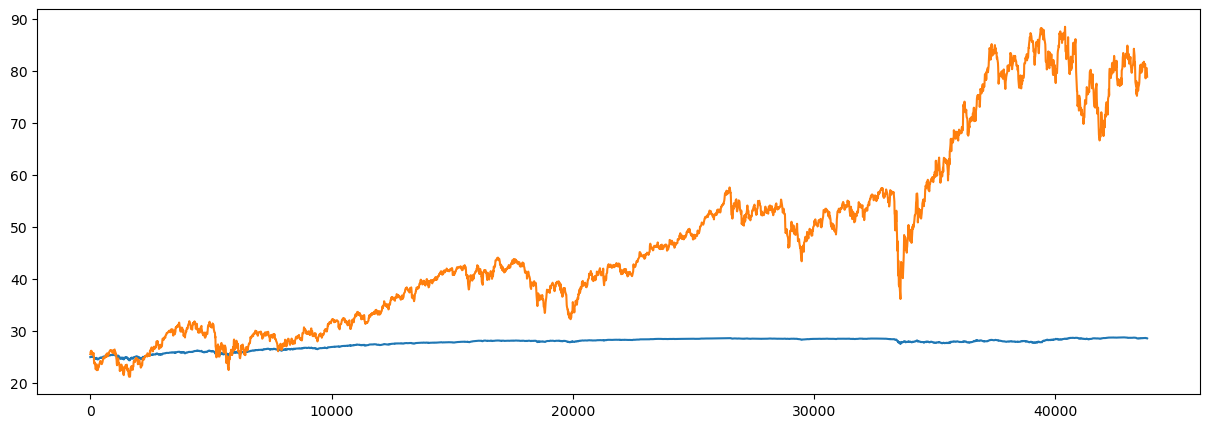

In [93]:
plt.plot(processed_full[processed_full['tic']=='XLB']['prediction'])
plt.plot(processed_full[processed_full['tic']=='XLB']['close'])

In [68]:
#Indicator 재조정

INDICATORS = INDICATORS + ['prediction']

### Data split

전체를 다 학습하면 안되는거 아닌가? 

In [69]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

26613
3591


### environment setting

In [74]:
stock_dimension = len(train.tic.unique()) 
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension #현재 상태를 나타내는 state를 정의. 1+ ticker 개수 x2 + 인디케이터 개수 x ticker개수 
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 9, State Space: 100


In [75]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [76]:
print(buy_cost_list)
num_stock_shares

[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]


[0, 0, 0, 0, 0, 0, 0, 0, 0]

In [77]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


Training Part using A2C

In [45]:
agent = DRLAgent(env = env_train)

if_using_a2c = True ##a2c만 사용해보자
if_using_ddpg = False
if_using_ppo = False
if_using_td3 = False
if_using_sac = False

In [46]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)


{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c


In [47]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000) if if_using_a2c else None

--------------------------------------
| time/                 |            |
|    fps                | 177        |
|    iterations         | 100        |
|    time_elapsed       | 2          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -12.9      |
|    explained_variance | -0.478     |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -19.6      |
|    reward             | 0.09383933 |
|    std                | 1.01       |
|    value_loss         | 3.73       |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 178       |
|    iterations         | 200       |
|    time_elapsed       | 5         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -12.9     |
|    explained_variance | -0.198    |
|    learning_rate      | 0.0007  

## In-sample Performance

Assume that the initial capital is $1,000,000.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

주식시장 변동성지수를 이용해서 언제 위험한 상황인지를 나타낸다.

In [48]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [49]:
insample_risk_indicator.vix.describe()

count    2957.000000
mean       18.105293
std         7.272476
min         9.140000
25%        13.370000
50%        16.209999
75%        20.629999
max        82.690002
Name: vix, dtype: float64

In [50]:
insample_risk_indicator.vix.quantile(0.996)

57.212001831054636

In [51]:
insample_risk_indicator.turbulence.describe()

count    2957.000000
mean        9.575001
std        12.733814
min         0.000000
25%         3.875532
50%         6.851105
75%        11.555221
max       258.291925
Name: turbulence, dtype: float64

In [52]:
insample_risk_indicator.turbulence.quantile(0.996)

88.28360862735143

In [53]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

VIX threshold 70으로 지정함

In [54]:
trained_model = trained_a2c
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_model, 
    environment = e_trade_gym)

hit end!


In [55]:
df_account_value_a2c.shape

(399, 2)

## Back testing

In [56]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
df_account_value_a2c.to_csv("df_account_value_a2c.csv")
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI", 
        start = TRADE_START_DATE,
        end = TRADE_END_DATE)
stats = backtest_stats(df_dji_, value_col_name = 'close')
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value_a2c['date']
df_dji['account_value'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
df_dji.to_csv("df_dji+.csv")

result = pd.DataFrame(df_result_a2c)

"""result = pd.merge(df_result_a2c, df_result_ddpg, left_index=True, right_index=True)
result = pd.merge(result, df_result_td3, left_index=True, right_index=True)
result = pd.merge(result, df_result_ppo, left_index=True, right_index=True)
result = pd.merge(result, df_result_sac, left_index=True, right_index=True)
result = pd.merge(result, MVO_result, left_index=True, right_index=True)"""
result = pd.merge(result, df_dji, left_index=True, right_index=True)


result.columns = ['a2c','dji']

print("result: ", result)
result.to_csv("result.csv")

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (400, 8)
Annual return         -0.022145
Cumulative returns    -0.034921
Annual volatility      0.176822
Sharpe ratio          -0.038668
Calmar ratio          -0.100930
Stability              0.215672
Max drawdown          -0.219408
Omega ratio            0.993578
Sortino ratio         -0.053987
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.003436
Daily value at risk   -0.022305
dtype: float64
result:                       a2c           dji
date                                  
2021-10-01  1.000000e+06  1.000000e+06
2021-10-04  9.995889e+05  9.905746e+05
2021-10-05  1.000393e+06  9.996566e+05
2021-10-06  1.000471e+06  1.002637e+06
2021-10-07  1.003040e+06  1.012483e+06
...                  ...           ...
2023-04-27  9.428106e+05  9.854252e+05
2023-04-28  9.499768e+05  9.933491e+05
2023-05-01  9.455484e+05  9

c:\Users\se99a\anaconda3\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


<Figure size 1500x500 with 0 Axes>

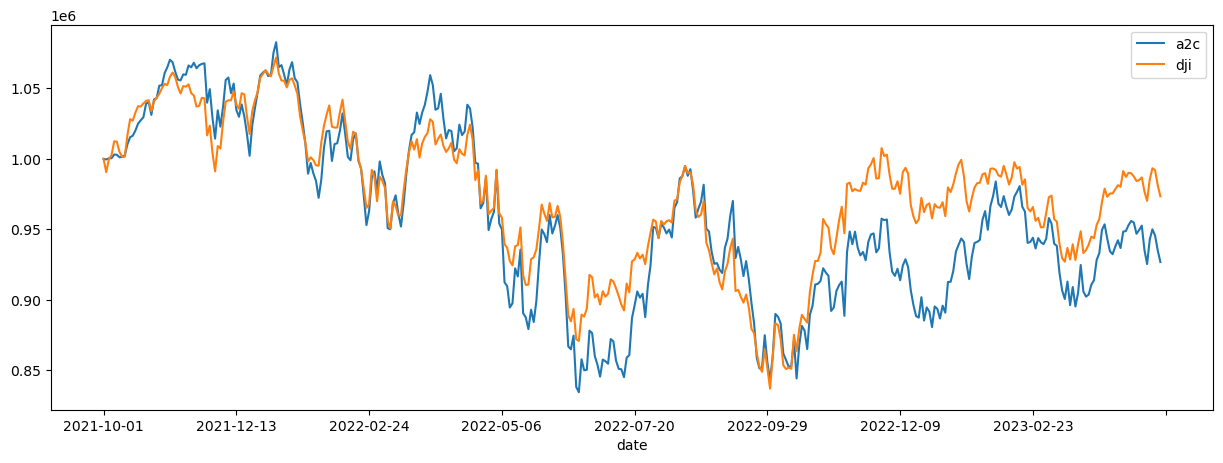

In [57]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();

In [58]:
df_result_a2c.iloc[-1,0]

926730.9201601871

In [59]:
print('A2C로 얻은 투자 수익률>>', round((df_result_a2c.iloc[-1,0]/df_result_a2c.iloc[0,0]-1)*100,2),'%')

A2C로 얻은 투자 수익률>> -7.33 %


In [60]:
df_daily_return = df_account_value_a2c

In [61]:
df_actions_a2c

,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
date,,,,,,,,,
2021-10-01,100,100,100,100,0,61,0,95,88
2021-10-04,100,100,100,100,0,61,0,95,88
2021-10-05,100,100,100,100,0,61,0,95,88
2021-10-06,100,100,100,100,0,61,0,95,88
2021-10-07,100,100,100,100,0,61,0,95,88
...,...,...,...,...,...,...,...,...,...
2023-04-26,0,0,0,0,0,0,0,0,0
2023-04-27,0,0,0,0,0,0,0,0,0
2023-04-28,0,0,0,0,0,0,0,0,0
